In [1]:
from keras import layers
from keras import models
import tensorflow as tf
from utils import constants
from utils import utils

2022-11-24 21:45:29.605930: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
#CONFIG
epochs = 50
batch_size = 8
learning_rate = 1e-5
input_shape = (224,224)
shape = (224,224,3)
layers_to_unfreeze = 20

In [4]:
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
                    constants.TRAIN_DIRECTORY,
                    target_size=input_shape,
                    batch_size=batch_size,
                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
                        constants.VALIDATION_DIRECTORY,
                        target_size=input_shape,
                        batch_size=batch_size,
                        class_mode='categorical')
                 


Found 5934 images belonging to 4 classes.
Found 744 images belonging to 4 classes.


In [5]:
def build_model(num_classes, learning_rate):
    inputs = layers.Input(shape=shape)
    img_augmentation = models.Sequential(name="img_augmentation")
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model


def unfreeze_model(model, learning_rate):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-layers_to_unfreeze:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
            print(layer.name)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])



In [6]:
model = build_model(4,learning_rate=learning_rate)
unfreeze_model(model,learning_rate=learning_rate) 
model.summary()

2022-11-24 21:47:01.765867: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-24 21:47:01.823952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-24 21:47:01.824898: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-24 21:47:01.826164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the ap

block7a_expand_conv
block7a_expand_activation
block7a_dwconv
block7a_activation
block7a_se_squeeze
block7a_se_reshape
block7a_se_reduce
block7a_se_expand
block7a_se_excite
block7a_project_conv
top_conv
top_activation
avg_pool
top_dropout
pred
Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img_augmentation (Sequential)  multiple             0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 224

In [7]:
hist = model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Epoch 1/50


2022-11-24 21:47:18.405906: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-11-24 21:47:20.751662: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-24 21:47:21.682762: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


742/742 [==============================] - 140s 176ms/step - loss: 1.4665 - accuracy: 0.4019 - val_loss: 1.0871 - val_accuracy: 0.5349
Epoch 2/50
742/742 [==============================] - 130s 175ms/step - loss: 1.1741 - accuracy: 0.5329 - val_loss: 0.9348 - val_accuracy: 0.6371
Epoch 3/50
742/742 [==============================] - 127s 170ms/step - loss: 1.0564 - accuracy: 0.5858 - val_loss: 0.8441 - val_accuracy: 0.6801
Epoch 4/50
742/742 [==============================] - 127s 172ms/step - loss: 0.9443 - accuracy: 0.6318 - val_loss: 0.8004 - val_accuracy: 0.7097
Epoch 5/50
742/742 [==============================] - 128s 172ms/step - loss: 0.8834 - accuracy: 0.6554 - val_loss: 0.7495 - val_accuracy: 0.7164
Epoch 6/50
742/742 [==============================] - 128s 173ms/step - loss: 0.8624 - accuracy: 0.6579 - val_loss: 0.7137 - val_accuracy: 0.7446
Epoch 7/50
742/742 [==============================] - 128s 172ms/step - loss: 0.8151 - accuracy: 0.6908 - val_loss: 0.6772 - val_accura

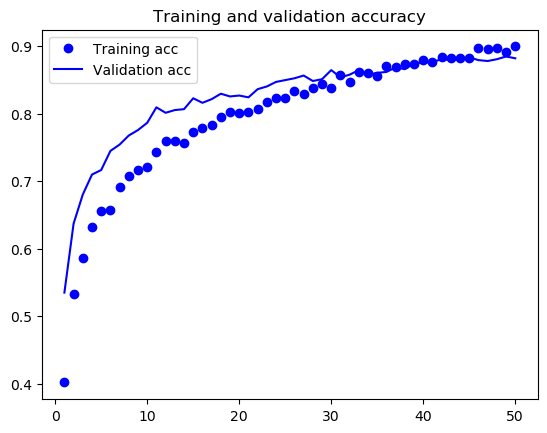

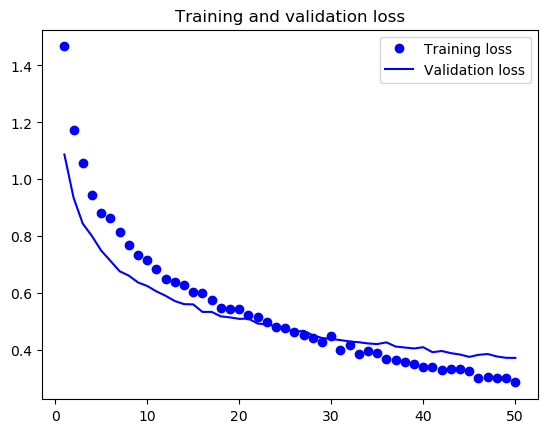

In [8]:
utils.plot_graphs(hist.history)

In [9]:
utils.show_stats([hist])

Max Accuracy:  0.8992248177528381  Mean Accuracy:  0.7967778927087784  Max Val Accuracy:  0.8844085931777954  Mean Val Accuracy 0.8235483884811401
Min Loss:  0.2864394783973694  Mean loss:  0.5425555354356766 Min Val Loss:  0.37266847491264343  Mean Val Loss:  0.5198474681377411


In [10]:
utils.save_dict_as_json(hist.history, "EfficientNet")

In [11]:
model.save('EfficientNet.h5')